In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv src/.env

In [2]:
import os
os.chdir('/Users/kushagrasharma/coding/hormozlab/src')

from tabulate import tabulate
import numpy as np
from numpy import linalg
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance, skew
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import torchvision

from tqdm import tqdm

from src.AutoEncoder import AE, Encoder, Decoder
from src.Binary2LatentNN import Binary2LatentNN
from src.Binary2TranscriptomeNN import Binary2TranscriptomeNN
from src.utils import *

import seaborn as sns
%matplotlib inline

In [3]:
DATA_DIR = os.environ.get("DATA_DIR")
MODELS_DIR = os.environ.get("MODELS_DIR")

binary_matrix_filepath = MODELS_DIR + 'binary_matrix.npy'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
### Loading Data
binary_matrix = torch.tensor(np.load(binary_matrix_filepath)).float()

train_full = pd.read_csv(DATA_DIR + 'scvi_train_set_gapdh.csv', header=None).to_numpy()
test_full = pd.read_csv(DATA_DIR + 'scvi_test_set_gapdh.csv', header=None).to_numpy()
valid_full = pd.read_csv(DATA_DIR + 'scvi_valid_set_gapdh.csv', header=None).to_numpy()

train_umap = pd.read_csv(DATA_DIR + 'train_coords.csv', header=None).to_numpy()
test_umap = pd.read_csv(DATA_DIR + 'test_coords.csv', header=None).to_numpy()
valid_umap = pd.read_csv(DATA_DIR + 'valid_coords.csv', header=None).to_numpy()

train_tensor = torch.tensor(train_full).float()
valid_tensor = torch.tensor(valid_full).float()
test_tensor = torch.tensor(test_full).float()

train_binary_tensor = torch.matmul(train_tensor, binary_matrix)
valid_binary_tensor = torch.matmul(valid_tensor, binary_matrix)
test_binary_tensor = torch.matmul(test_tensor, binary_matrix)

gaussian_train = np.load(DATA_DIR + 'truncated_gaussian_sigma_10thNN.npy')

closest_cell_to_valid = np.load(DATA_DIR + 'closest_cell_to_valid.npy')
closest_cell_to_test = np.load(DATA_DIR + 'closest_cell_to_test.npy')

gaussian_valid = np.apply_along_axis(lambda x: gaussian_train[x,:], 0, closest_cell_to_valid)
gaussian_test = np.apply_along_axis(lambda x: gaussian_train[x,:], 0, closest_cell_to_test)

graph = np.load(DATA_DIR + "adjacency_15NN.npy")

N_train_cells = len(graph)
N_test_cells = len(test_tensor)

### Get Laplacian
laplacian_all = get_laplacian_from_tome_data(train_full)

### Compute eigen
lambda_all, v_all = get_laplacian_eig_from_laplacian(laplacian_all)

## Diving into method #1

We want to examine the results from our methods carefully to evaluate their performance and see what is happening in our analysis. We choose to first examine our first distribution reconstruction method, where we start with a binary combination, use a neural network to reconstruct the Laplacian coefficients, and then use the Laplacian coefficients to reconstruct the distribution.

In [5]:
binaryToLaplacian = torch.load(MODELS_DIR + 'binaryToLaplacian.pt').eval()

In [6]:
toGraph = lambda X: np.apply_along_axis(lambda y: laplacian_coefficients_to_probability(y, v_all), 1, X)
toTensor = lambda x: torch.tensor(x).float()

In [7]:
## Error metrics
fn_on_matrix = lambda fn: lambda Y, Yhat: np.array([fn(Y[i,:], Yhat[i,:]) for i in range(len(Y))])
wassersteinOnMatrix = fn_on_matrix(wasserstein_distance)
klDivOnMatrix = fn_on_matrix(kl_div)
jsOnMatrix = fn_on_matrix(jensenshannon)


errorMetricOnMatrix = jsOnMatrix
errorMetric = lambda Y, Yh: errorMetricOnMatrix(Y, Yh).mean()

In [8]:
transform = [binaryToLaplacian, toGraph]

with torch.no_grad():
    results, error = transform_and_compute_error(test_binary_tensor, gaussian_test, 
                                            transform, errorMetric)

In [9]:
uniform = np.ones(N_train_cells) / (N_train_cells)
uniform_matrix = np.tile(uniform, (N_test_cells, 1))

uniform_control_error = errorMetric(uniform_matrix, gaussian_test)
error_dist = errorMetricOnMatrix(results, gaussian_test)

The error metric we use to measure the fidelity of reconstruction is the Jensen Shannon Divergence (JS Divergence), a standard method for measuring the similarity between two distributions. It's based on the KL Divergence, but is symmetric. We first examine a scatter plot of the JS Divergence and overlay the control JS Divergence as an initial exploration.

Text(0, 0.5, 'Divergence Measure')

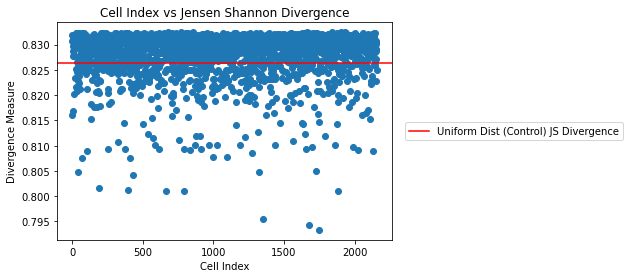

In [10]:
plt.scatter(np.arange(len(error_dist)), error_dist)
plt.axhline(y=uniform_control_error, color='r', linestyle='-', label='Uniform Dist (Control) JS Divergence')
plt.title("Cell Index vs Jensen Shannon Divergence")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.xlabel("Cell Index")
plt.ylabel("Divergence Measure")

In [11]:
error_dist_centered_on_control = error_dist - errorMetric(uniform_matrix, gaussian_test)
error_distance_scaled = error_dist_centered_on_control / np.std(error_dist_centered_on_control)

We'd like to rescale the measure, so we center it on the control JS Divergence and rescale by the standard deviation.

Text(0, 0.5, 'Divergence Measure')

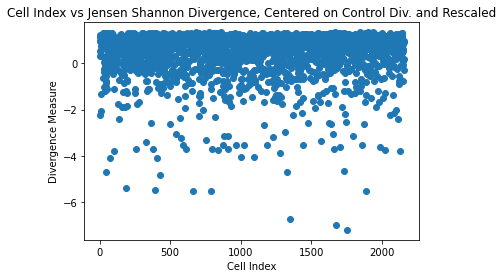

In [12]:
plt.scatter(np.arange(len(error_distance_scaled)), error_distance_scaled)
plt.title("Cell Index vs Jensen Shannon Divergence, Centered on Control Div. and Rescaled")
plt.xlabel("Cell Index")
plt.ylabel("Divergence Measure")

We'd next like to understand the distribution of the divergence, so we plot both the PDF and CDF. 

Text(0.5, 1.0, 'Histogram (PDF) of JS Divergence, Centered and Scaled')

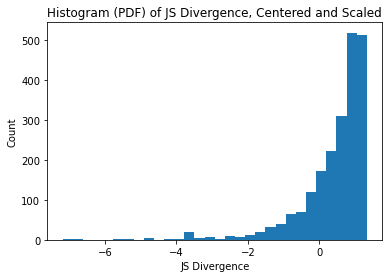

In [13]:
plt.hist(error_distance_scaled, bins=30)
plt.ylabel("Count")
plt.xlabel("JS Divergence")
plt.title("Histogram (PDF) of JS Divergence, Centered and Scaled")

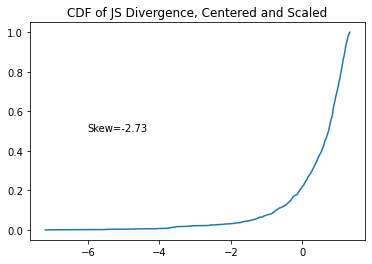

In [14]:
X2 = np.sort(error_distance_scaled)
F2 = np.array(range(len(error_distance_scaled)))/float(len(error_distance_scaled))
plt.plot(X2, F2)
plt.title("CDF of JS Divergence, Centered and Scaled")
one_array = np.abs(X2)
one_idx = one_array.argmin()
# plt.plot((X2[one_idx], X2[one_idx]), (plt.ylim()[0], F2[one_idx]), 'r')
# plt.plot((plt.xlim()[0], X2[one_idx]), (F2[one_idx], F2[one_idx]), 'r')
ax = plt.gca()
output_coords = lambda x: ax.transLimits.inverted().transform(x)
# plt.axhline(y=F2[one_idx], xmin=0, xmax=0.49, color='r', label="Density at Control JS Div.={:.2f}".format(F2[one_idx]))
# plt.axvline(x=0, ymin=0, ymax=0.49, color='r')
plt.text(x=-6, y=0.5, s="Skew={:.2f}".format(skew(error_distance_scaled)))
plt.show()

The skew is negative, but the cumulative density below $0$ is only $0.17$, so this isn't performing particularly well. 

We'll thus go ahead and plot 5 cells from the bottom $10\%$ of the JS Divergence distribution (the cells with the best reconstructions) and 5 cells from the top $10\%$ of the JS Divergence distribution (the cells with the worst reconstructions).

In [15]:
bten_array = np.abs(F2 - 0.1)
bten_idx = bten_array.argmin()
bten_threshold = X2[bten_idx]
bten_idxs = np.where(error_distance_scaled <= bten_threshold)[0]
bten_idxs = np.random.choice(bten_idxs, 5, replace=False)

tten_array = np.abs(F2 - 0.9)
tten_idx = tten_array.argmin()
tten_threshold = X2[tten_idx]
tten_idxs = np.where(error_distance_scaled >= tten_threshold)[0]
tten_idxs = np.random.choice(tten_idxs, 5, replace=False)


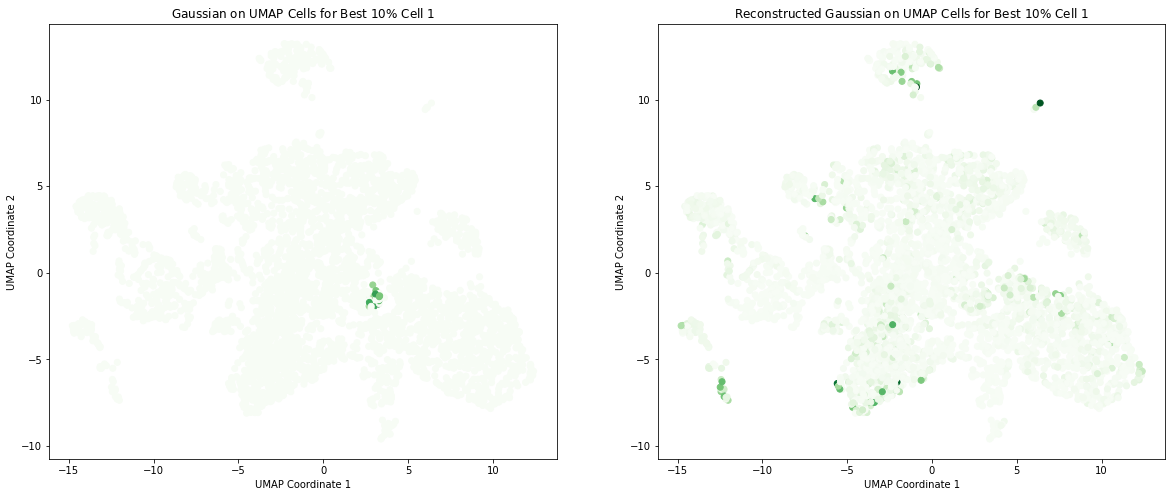

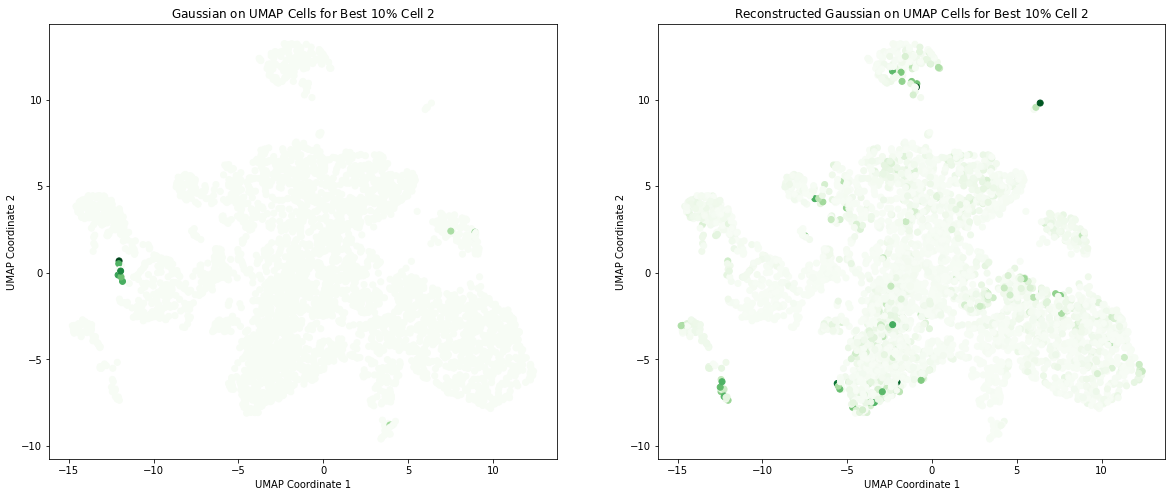

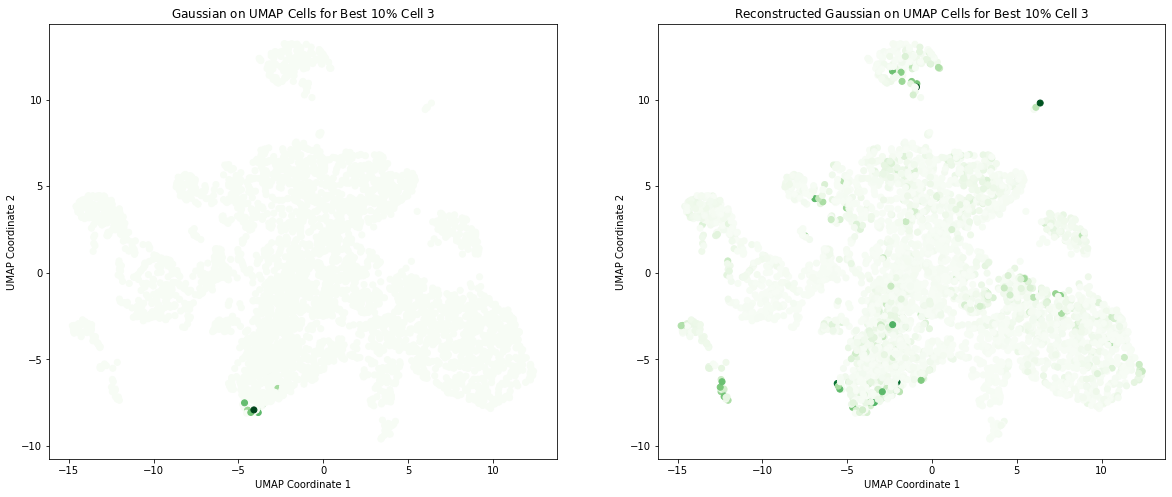

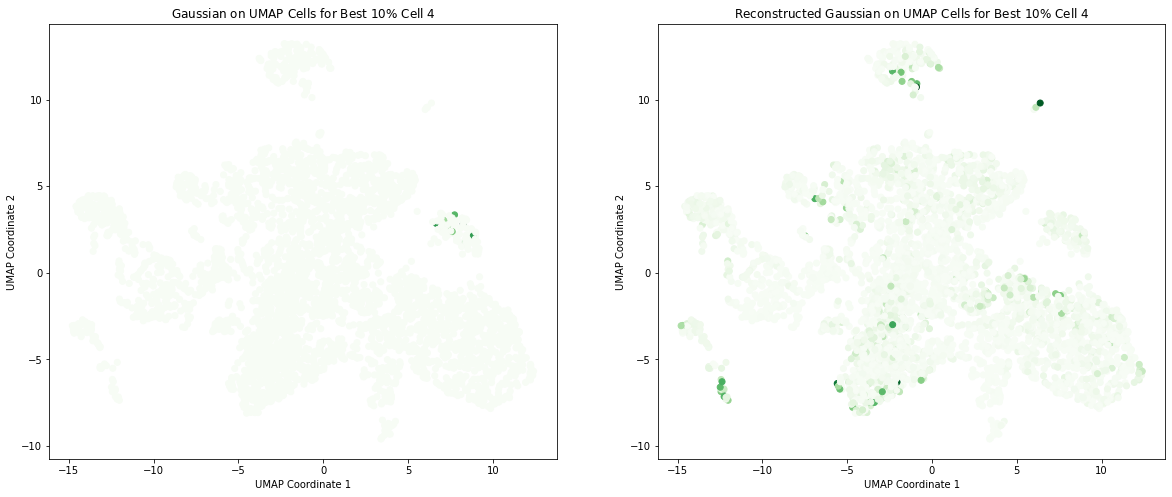

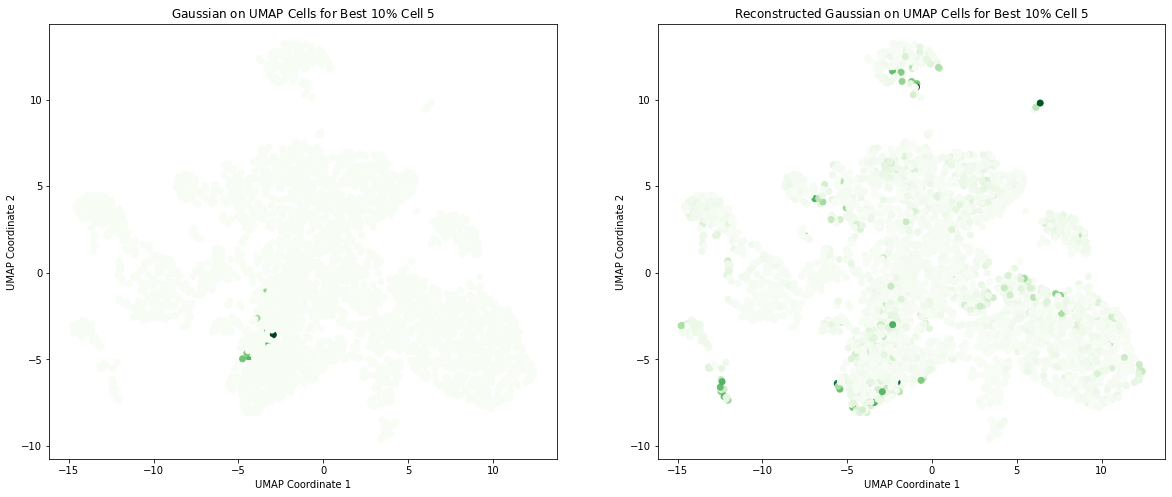

In [16]:
for i, idx in enumerate(bten_idxs):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    ax1.scatter(train_umap[:,0], train_umap[:,1], c=gaussian_test[idx,:], cmap='Greens')
    ax1.set_title(r'Gaussian on UMAP Cells for Best $10\%$ Cell {}'.format(i+1))
    ax1.set_xlabel("UMAP Coordinate 1")
    ax1.set_ylabel("UMAP Coordinate 2")
    
    ax2.scatter(train_umap[:,0], train_umap[:,1], c=results[idx,:], cmap='Greens')
    ax2.set_title(r'Reconstructed Gaussian on UMAP Cells for Best $10\%$ Cell {}'.format(i+1))
    ax2.set_xlabel("UMAP Coordinate 1")
    ax2.set_ylabel("UMAP Coordinate 2")
    plt.show()

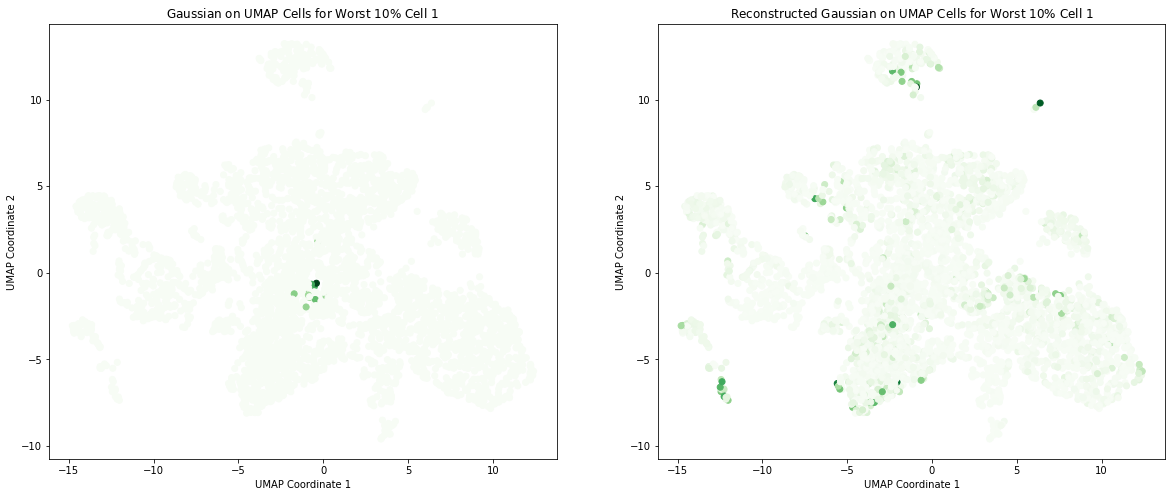

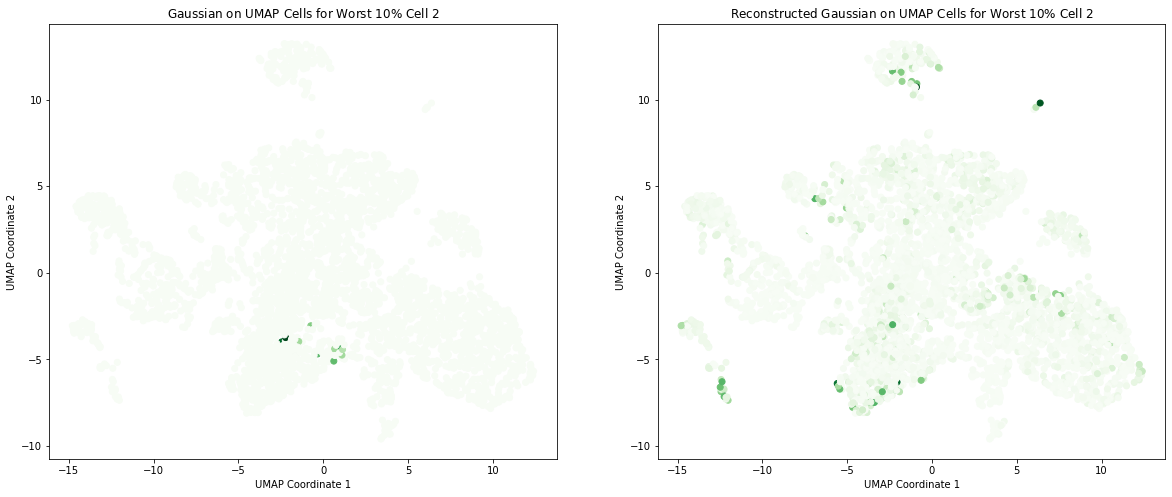

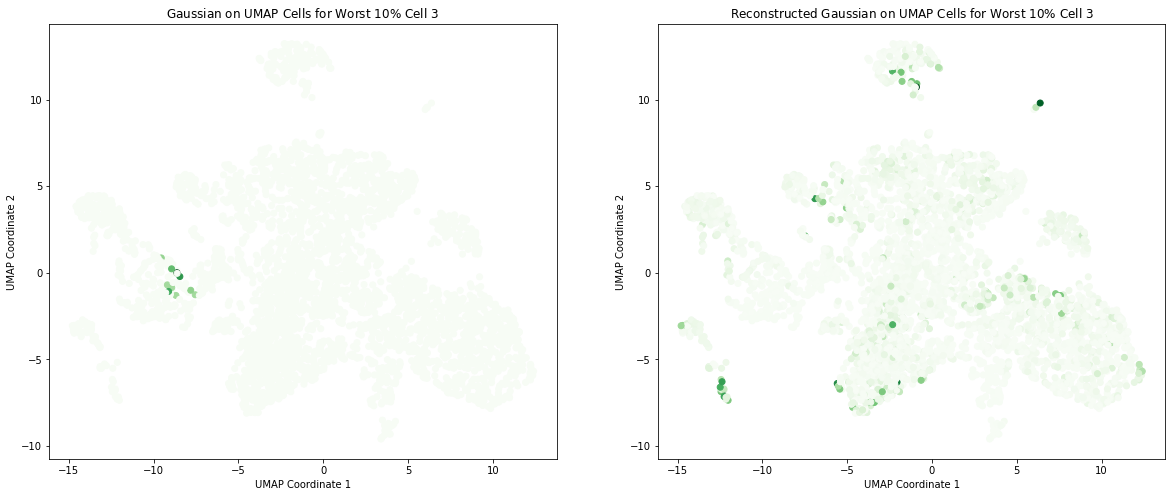

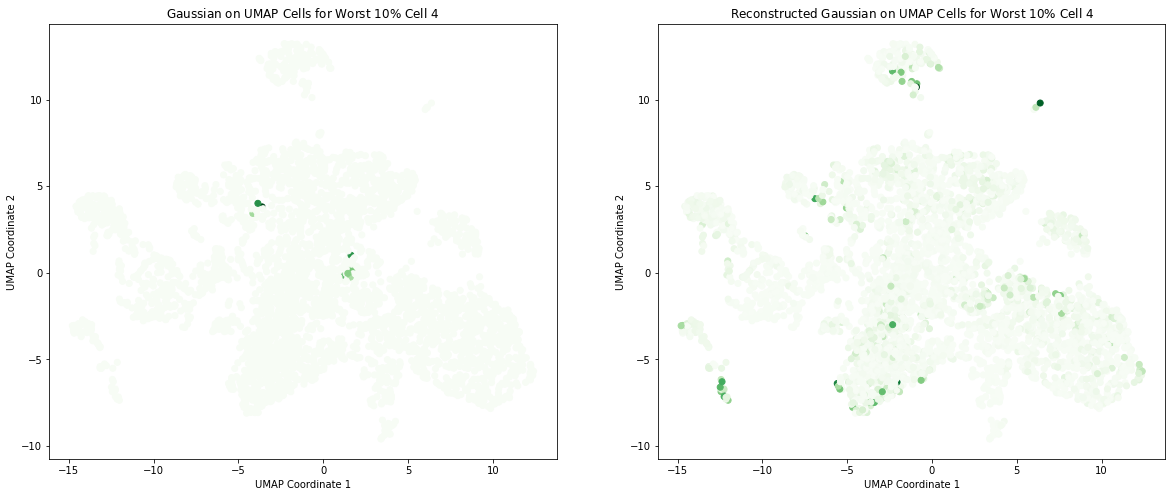

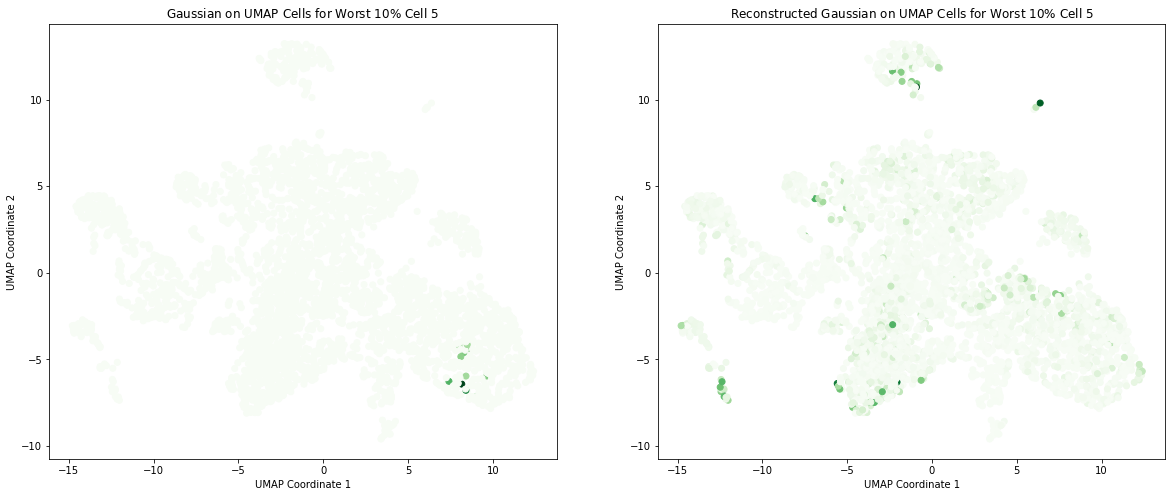

In [17]:
for i, idx in enumerate(tten_idxs):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    ax1.scatter(train_umap[:,0], train_umap[:,1], c=gaussian_test[idx,:], cmap='Greens')
    ax1.set_title(r'Gaussian on UMAP Cells for Worst $10\%$ Cell {}'.format(i+1))
    ax1.set_xlabel("UMAP Coordinate 1")
    ax1.set_ylabel("UMAP Coordinate 2")
    
    ax2.scatter(train_umap[:,0], train_umap[:,1], c=results[idx,:], cmap='Greens')
    ax2.set_title(r'Reconstructed Gaussian on UMAP Cells for Worst $10\%$ Cell {}'.format(i+1))
    ax2.set_xlabel("UMAP Coordinate 1")
    ax2.set_ylabel("UMAP Coordinate 2")
    plt.show()

We could've guessed from the narrow spread of the JS Divergence that the difference between good reconstructions and bad reconstructions were minimal, but this confirmed it - both the good and bad distributions have extremely diffuse reconstructions, which explains why the spread was low.